In [2]:
import numpy as np
import torch
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import sys

sys.path.append('/project/Stat/s1155168529/programs/DDML/code_den_est')
from model_train import *

configuration and training

In [19]:
D = 400
n = 300
p_x = 2

learning_rate = 1e-2
reg_x = 10 * np.log(n)
# reg_x = 2 * n 
# reg_x = n 
# reg_x = 0

device = torch.device("cpu")
seed = 42
np.random.seed(seed)

mat_x = np.random.randn(n, p_x) + 1
mat_x_test = np.random.randn(n, p_x) + 3

ts_x = torch.from_numpy(mat_x).float().to(device)
ts_x_test = torch.from_numpy(mat_x_test).float().to(device)

model_den_est,_,_ = den_X(ts_x, D, learning_rate, reg_x, n_iter = 2000)

Iteration 0, Loss: 16146.5908203125, ell: 1.0
Iteration 200, Loss: 136.2319793701172, ell: 1.0
Iteration 400, Loss: 134.8819580078125, ell: 1.0
Iteration 600, Loss: 134.8820037841797, ell: 1.0
Iteration 800, Loss: 134.88201904296875, ell: 1.0
Iteration 1000, Loss: 134.88198852539062, ell: 1.0
Iteration 1200, Loss: 134.88198852539062, ell: 1.0
Iteration 1400, Loss: 134.88198852539062, ell: 1.0
Iteration 1600, Loss: 134.88198852539062, ell: 1.0
Iteration 1800, Loss: 134.88198852539062, ell: 1.0


0.007783597

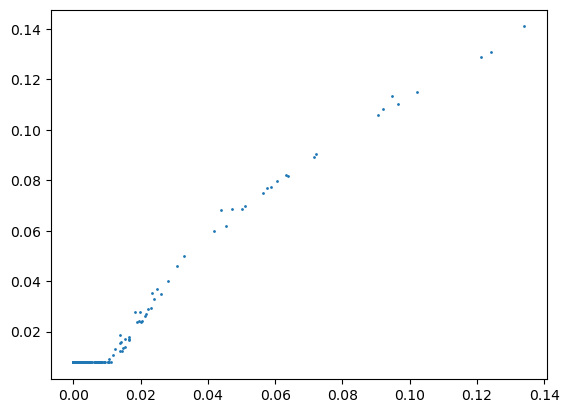

In [20]:
vec_den_est = model_den_est.pred(ts_x_test, bl_shift=True).detach().cpu().numpy()

vec_den_truth = stats.multivariate_normal.pdf(mat_x_test, mean=np.ones(p_x) * 1, cov=np.eye(p_x))

plt.scatter(vec_den_truth, vec_den_est, s=1)

vec_den_est.min()

In [7]:
print(">> beta mean: ", model_den_est.beta.mean())

print(">> phi mean", model_den_est.phi_x(ts_x).mean())

scale = model_den_est.beta.mean() / model_den_est.phi_x(ts_x).mean()
print(">> scale: ", scale)

>> beta mean:  tensor(0.0947, grad_fn=<MeanBackward0>)
>> phi mean tensor(0.0247, grad_fn=<MeanBackward0>)
>> scale:  tensor(3.8351, grad_fn=<DivBackward0>)


numeric estimation

In [19]:
vec_x_test = np.linspace(np.quantile(mat_x_test[:, 0], 0.05), np.quantile(mat_x_test[:, 0], 0.95), 100)
vec_y_test = np.linspace(np.quantile(mat_x_test[:, 1], 0.05), np.quantile(mat_x_test[:, 1], 0.95), 100)
mat_x_test_grid = np.array(np.meshgrid(vec_x_test, vec_y_test)).T.reshape(-1, 2)
mat_x_test_grid = torch.from_numpy(mat_x_test_grid).float().to(device)

den_x_est_test = model_den_est.pred(mat_x_test_grid)
den_x_est_test = den_x_est_test.cpu().detach().numpy()

min_shift = np.quantile(den_x_est_test, 0.05)

den_x_est_test_shift = den_x_est_test - min_shift
den_x_est_test_shift[den_x_est_test_shift < 0] = 0

scale_shift = np.sum(den_x_est_test_shift) * (np.max(vec_x_test) - np.min(vec_x_test)) / 100 * (np.max(vec_y_test) - np.min(vec_y_test)) / 100

print('Scale shift:', scale_shift)

den_x_est_test_shift = den_x_est_test_shift / scale_shift 

Scale shift: 8.934086311519486


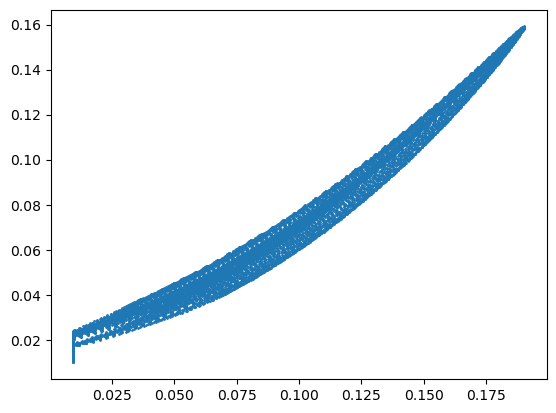

In [17]:
vec_den_est = stats.multivariate_normal.pdf(mat_x_test_grid, mean=np.ones(p_x), cov=np.eye(p_x))

den_x_est_test_shift = 0.95 * den_x_est_test_shift + 0.05 * np.max(den_x_est_test_shift)

plt.scatter(den_x_est_test_shift, vec_den_est, s=1)

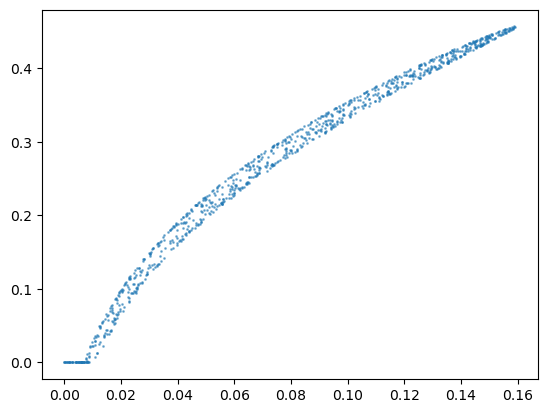

In [43]:
vec_den_est = model_den_est.pred(ts_x_test).detach().numpy()
vec_den_est[vec_den_est < np.quantile(vec_den_est, 0.05)] = np.quantile(vec_den_est, 0.05)
vec_den_est = vec_den_est - np.min(vec_den_est)

vec_den_truth = stats.multivariate_normal.pdf(
    mat_x_test, mean=np.ones(p_x), cov=np.eye(p_x)
)

plt.scatter(vec_den_truth, vec_den_est, s=1, alpha=0.5)

## mixture Gaussian 

In [19]:
## configuration
D = 200
learning_rate = 1e-3
n = 1000
p_x = 1

device = torch.device("cpu")

## generate data
seed = 43
np.random.seed(seed)

mat_x = np.random.randn(n, p_x) + np.random.binomial(
    n = 1, p = 0.5, size = (n, p_x)
) * 10.0 - 5.0

ts_x = torch.from_numpy(mat_x).float().to(device)

model_x, optimizer, omega = den_X(
    ts_x, D = D, learning_rate = learning_rate, 
    reg = n, 
    # reg = 6 * n, 
    # reg = 20 * np.log(n),
    # reg = 1,
    # reg = 1e-2
    # reg = 1e-3
    n_iter=5000
)


Iteration 0, Loss: 156709.984375, ell: 1.0
Iteration 500, Loss: 55502.6796875, ell: 1.0
Iteration 1000, Loss: 20620.783203125, ell: 1.0
Iteration 1500, Loss: 6717.359375, ell: 1.0
Iteration 2000, Loss: 2945.994140625, ell: 1.0
Iteration 2500, Loss: 2276.0703125, ell: 1.0
Iteration 3000, Loss: 2204.13818359375, ell: 1.0
Iteration 3500, Loss: 2199.9775390625, ell: 1.0
Iteration 4000, Loss: 2199.8662109375, ell: 1.0
Iteration 4500, Loss: 2199.864990234375, ell: 1.0


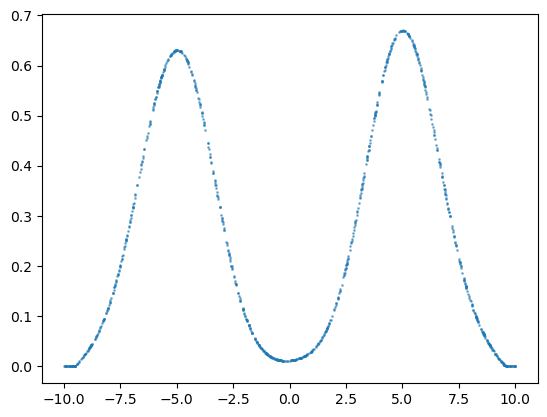

In [20]:
mat_x_pred = np.random.rand(n, p_x) * 20.0 - 10.0
ts_x_pred = torch.from_numpy(mat_x_pred).float().to(device)

den_x_est = model_x.pred(ts_x_pred).detach().numpy()

# den_x_est[den_x_est < np.quantile(den_x_est, 0.05)] = np.quantile(den_x_est, 0.05)
den_x_est[den_x_est < np.quantile(den_x_est, 0.05)] = np.quantile(den_x_est, 0.05)
den_x_est = den_x_est - np.min(den_x_est)

plt.scatter(mat_x_pred, den_x_est, s=1, alpha=0.5)

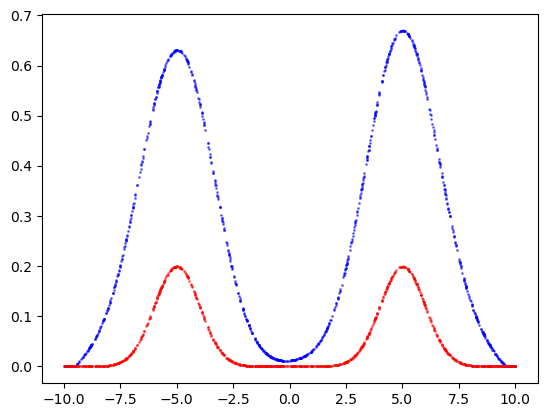

In [21]:
den_x_truth = 0.5 * stats.multivariate_normal.pdf(
    mat_x_pred, mean=np.zeros(p_x) + 5, cov=np.eye(p_x)
) + 0.5 * stats.multivariate_normal.pdf(
    mat_x_pred, mean=np.zeros(p_x) - 5, cov=np.eye(p_x)
)


plt.scatter(mat_x_pred, den_x_est, s=1, alpha=0.5, color = 'blue')
plt.scatter(mat_x_pred, den_x_truth, s=1, alpha=0.5, color = 'red')
# plt.scatter(den_x_truth, den_x_est, s=1, alpha=0.5)

(array([ 12.61944266,   7.71187357,   5.60864118,   0.70108015,
          3.50539891,   5.60863825,   3.50540074,   2.80431913,
          2.10323989,   2.10323989,   4.20647979,   0.70107987,
        134.60735319,  33.6518339 ,   4.20647979,  10.51619947,
          9.8151195 ,  10.51619672,   2.10324044,   0.        ,
          2.10323934,   2.80431913,   3.50540074,   0.70108015,
          1.40215883,   0.70108015,   1.4021603 ,   3.50540074,
          3.50539708,   4.20648089]),
 array([-0.04560343, -0.0420375 , -0.03847157, -0.03490565, -0.03133972,
        -0.02777379, -0.02420786, -0.02064194, -0.01707601, -0.01351008,
        -0.00994416, -0.00637823, -0.0028123 ,  0.00075363,  0.00431955,
         0.00788548,  0.01145141,  0.01501733,  0.01858326,  0.02214919,
         0.02571512,  0.02928104,  0.03284697,  0.0364129 ,  0.03997882,
         0.04354475,  0.04711068,  0.05067661,  0.05424253,  0.05780846,
         0.06137439]),
 <BarContainer object of 30 artists>)

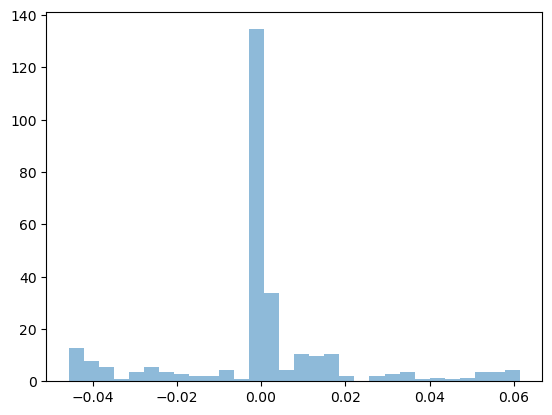

In [7]:
vec_beta = model_x.beta.detach().numpy()

plt.hist(vec_beta, bins=30, density=True, alpha=0.5, label="beta")

## small sample size

Iteration 0, Loss: 150819.890625, ell: 1.0
Iteration 200, Loss: 1442.071044921875, ell: 1.0
Iteration 400, Loss: 1432.398681640625, ell: 1.0
Iteration 600, Loss: 1432.3985595703125, ell: 1.0
Iteration 800, Loss: 1432.398681640625, ell: 1.0
Iteration 1000, Loss: 1432.398681640625, ell: 1.0
Iteration 1200, Loss: 1432.398681640625, ell: 1.0
Iteration 1400, Loss: 1432.398681640625, ell: 1.0
Iteration 1600, Loss: 1432.398681640625, ell: 1.0
Iteration 1800, Loss: 1432.398681640625, ell: 1.0


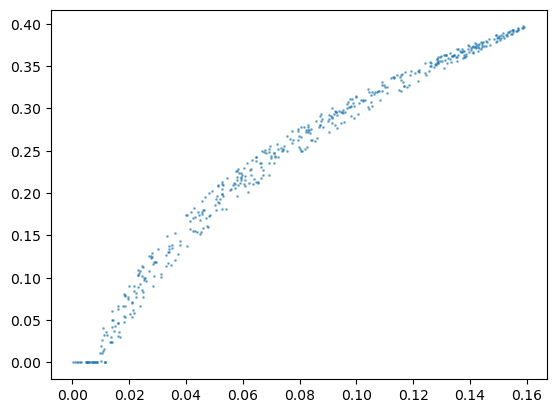

In [18]:
D = 200
n = 500
p_x = 2

learning_rate = 1e-2
# reg_x = 1e-2
# reg_x = 1
# reg_x = np.log(n)
# reg_x = 2 * D
reg_x = 2 * n

device = torch.device("cpu")
seed = 52
np.random.seed(seed)

mat_x = np.random.randn(n, p_x) + 3
mat_x_test = np.random.randn(n, p_x) + 3

ts_x = torch.from_numpy(mat_x).float().to(device)
ts_x_test = torch.from_numpy(mat_x_test).float().to(device)

model_den_est,_,_ = den_X(ts_x, D, learning_rate, reg_x, n_iter = 2000)
vec_den_est = model_den_est.pred(ts_x_test).detach().numpy()
vec_den_est[vec_den_est < np.quantile(vec_den_est, 0.05)] = np.quantile(vec_den_est, 0.05)
vec_den_est = vec_den_est - np.min(vec_den_est)

vec_den_truth = stats.multivariate_normal.pdf(
    mat_x_test, mean=np.zeros(p_x) + 3, cov=np.eye(p_x)
)

plt.scatter(vec_den_truth, vec_den_est, s=1, alpha=0.5)